# MySQL AI
MySQL AI provides developers to build rich applications with MySQL leveraging built in machine learning, GenAI, LLMs and semantic search. They can create vectors from documents stored in a local file system. Customers can deploy these AI applications on premise or migrate them to MySQL HeatWave for lower cost, higher performance, richer functionality and latest LLMs with no change to their application. This gives developers the flexibility to build their applications on MySQL EE and then deploy them either on premise or in the cloud.

### Fraud detection with Creditcard Dataset Notebook
This notebook explores the application of machine learning techniques to the Creditcard dataset, a popular dataset in machine learning, particularly for fraud detection tasks. Credit card fraud poses a significant threat to financial institutions and individuals alike, resulting in substantial financial losses and eroded trust. Traditional rule-based systems often struggle to keep pace with the evolving tactics of fraudsters, making machine learning-based anomaly detection a vital tool.

The dataset was collected during a two-day period and anonymized using Principal Component Analysis (PCA) to protect cardholder identities. It provides a realistic scenario for developing and evaluating fraud detection algorithms.

The dataset includes the following features:

- Time: Number of seconds elapsed between each transaction and the first transaction in the dataset.
- V1 - V28: Anonymized features obtained through PCA transformation. These represent various transaction attributes but their specific meanings are not provided to maintain confidentiality.
- Amount: Transaction amount.
- Class: Binary label indicating whether the transaction is fraudulent (1) or not (0). While we'll use this for evaluation, our unsupervised models will not be trained using this label.

Throughout this notebook, we will use MySQL AI AutoML to train an unsupervised anomaly detection model. In this context, "unsupervised" signifies that we'll be training our models without explicitly using the "Class" label (fraudulent or legitimate) during the training phase. Instead, we'll rely on the inherent patterns and structures within the transaction data to identify deviations from the norm.

### References
- https://blogs.oracle.com/mysql/post/announcing-mysql-ai
- https://dev.mysql.com/doc/mysql-ai/9.4/en/
- https://dev.mysql.com/doc/dev/mysql-studio/latest/#overview

### Prerequistises

- mysql-connector-python
- pandas 
- scikit-learn
- sqlalchemy
- matplotlib

In [24]:
import json
import os
import numpy as np
import pandas as pd
import sqlalchemy
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Connect to MySQL AI instance
We create a connection to an active MySQL AI instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your MySQL AI instance.

 - In MySQL Studio, connections are restricted to only allow localhost as the host. 
 - In MySQL Studio, the only accepted password values are the string unused or None. 

In [ ]:
HOST = 'localhost'
PORT = 3306
USER = 'root'
PASSWORD = 'unused'
SCHEMA = 'mlcorpus'


myconn = mysql.connector.connect(
    host=HOST,
    port=PORT,
    user=USER,
    password=PASSWORD,
    database=SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = myconn.cursor()

# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the Creditcard dataset and load it into a MySQL table
 
 Download link: https://figshare.com/articles/dataset/creditcard_Dataset/29270873?file=55234994

 After download, copy the dataset csv file into /var/lib/mysql-files folder

 Example: sudo cp /home/john_doe/creditcard.csv /var/lib/mysql-files


 MySQL Studio imposes a 5MB file upload limit. For files exceeding this size, you must place them in the designated secure directory in MySQL (e.g., /var/lib/mysql-files) and load them directly within MySQL. 
 
 Given that the credit card dataset is approximately 150MB in size, it must be transferred to the secure directory on the MySQL server (/var/lib/mysql-files), before it can be imported into MySQL using the LOAD DATA INFILE command.

 

In [0]:
# Drop table if exists
create_sql = """
DROP TABLE IF EXISTS mlcorpus.creditcard
"""
execute_sql(create_sql)

# Create an empty table
create_sql = """
CREATE TABLE IF NOT EXISTS mlcorpus.creditcard (
    Time FLOAT,
    V1 FLOAT, V2 FLOAT, V3 FLOAT, V4 FLOAT, V5 FLOAT, V6 FLOAT,
    V7 FLOAT, V8 FLOAT, V9 FLOAT, V10 FLOAT, V11 FLOAT, V12 FLOAT,
    V13 FLOAT, V14 FLOAT, V15 FLOAT, V16 FLOAT, V17 FLOAT, V18 FLOAT,
    V19 FLOAT, V20 FLOAT, V21 FLOAT, V22 FLOAT, V23 FLOAT, V24 FLOAT,
    V25 FLOAT, V26 FLOAT, V27 FLOAT, V28 FLOAT,
    Amount FLOAT,
    Class INT,
    INDEX (Class)
);
"""
execute_sql(create_sql)

""


In [0]:
# Load the data into table
load_sql = f"""
LOAD DATA INFILE '/var/lib/mysql-files/creditcard.csv'
INTO TABLE mlcorpus.creditcard
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\\n'
IGNORE 1 LINES
(Time, V1, V2, V3, V4, V5, V6, V7, V8, V9,
 V10, V11, V12, V13, V14, V15, V16, V17, V18, V19,
 V20, V21, V22, V23, V24, V25, V26, V27, V28,
 Amount, Class);
"""
execute_sql(load_sql)

""


Load the creditcard table into python using Pandas. Given the size of the dataset (~280K rows), we take a 10% uniform random sample of the dataset for the purpose of this notebook.

In [0]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Read the table into a DataFrame
df = pd.read_sql("SELECT * FROM mlcorpus.creditcard", con=sql_engine)
df = df.sample(frac=0.1, random_state=1)

### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [27]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1, stratify=df["Class"]
)
df_train = df_train.replace({np.nan: "NULL"})
df_test = df_test.replace({np.nan: "NULL"})

 ### Load the Creditcard train and test splits into MySQL tables
 We connect to the MySQL database using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (creditcard_train and creditcard_test) in the database, replacing any existing tables.

In [28]:
# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'creditcard_train' table in the database
df_train.to_sql(
    f"creditcard_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=1000,
    index=False,
)
# Write the testing DataFrame to the 'creditcard_test' table in the database
df_test.to_sql(
    f"creditcard_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=1000,
    index=False,
)

-9

### Create an AutoML model from the Creditcard training dataset
We create a machine learning model on the Creditcard dataset using the [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) API. Given this is unsupervised anomaly detection, we pass the target column name as NULL, and MySQL AI AutoML builds a model learning from the patterns inherent in the data. The model learns normal and anomalous patterns in the data, allowing it to predict the same for any new data points we give it during prediction. Given that the Class target column is present in the training table, we ask [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) to exclude it from the learned features. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [29]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{SCHEMA}.creditcard_train', NULL, JSON_OBJECT('task', 'anomaly_detection', 'exclude_column_list', JSON_ARRAY('Class')), @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine to compute the accuracy. The roc_auc metric for anomaly detection tells us how well the model can separate the normal transactions from the fraudulent ones. 

In [30]:
execute_sql(
    f"""CALL sys.ML_SCORE('{SCHEMA}.creditcard_test', 'Class', '{model}', 'roc_auc', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model roc_auc is {score*100:.2f}")

The model roc_auc is 90.89


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains an extra column ml_results which contains the predictions

In [31]:
execute_sql(f"""DROP TABLE IF EXISTS creditcard_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{SCHEMA}.creditcard_test', '{model}', '{SCHEMA}.creditcard_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT Time, V1, V2, V3, Class, ml_results FROM creditcard_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS creditcard_test_predictions""")
df_predictions.head()

,Time,V1,V2,V3,Class,ml_results
0,74165,-0.640130,1.071570,1.567180,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
1,94428,-1.528380,0.663147,0.723797,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
2,63603,0.953884,-0.806137,0.893374,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
3,131607,1.982120,-0.480906,-0.244874,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
4,66478,-0.659545,0.401359,2.268490,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."


### Getting a deeper understanding of the model's predictions

A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) in anomaly detection, while similar to its use in classification, needs a slightly different interpretation due to the often highly imbalanced nature of anomaly datasets. Here's a breakdown:

In anomaly detection, we typically have two classes:

- Normal (Negative): The majority class, representing typical, expected data.
- Anomaly (Positive): The minority class, representing unusual or unexpected data points.

The confusion matrix helps us understand how well our anomaly detection model performs by showing us how many data points were correctly and incorrectly classified. Here 0 means a normal transaction, and 1 means a fradulent transaction. Based on the diagram below, out of the 15 actual anomalies, we correctly labeled 7 of them as anomalies. We also marked 76 normal transcations as anomalies, which are our false positives.

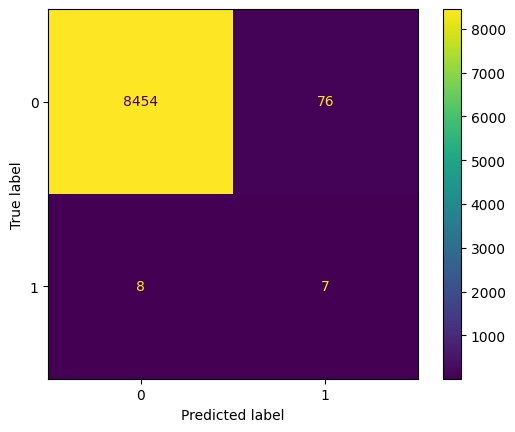

In [32]:
ConfusionMatrixDisplay.from_predictions(
    df_predictions["Class"],
    df_predictions["ml_results"]
    .apply(json.loads)
    .apply(lambda x: x["predictions"]["is_anomaly"]),
)
plt.show()

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.